# Object Detection with SSD
### Here we demostrate detection on example images using SSD with PyTorch

In [408]:
import cv2

In [409]:
cv2.__version__

'3.4.0'

In [404]:
print(sys.path)

['', '/Users/Sean/anaconda/lib/python36.zip', '/Users/Sean/anaconda/lib/python3.6', '/Users/Sean/anaconda/lib/python3.6/lib-dynload', '/Users/Sean/anaconda/lib/python3.6/site-packages', '/Users/Sean/anaconda/lib/python3.6/site-packages/Sphinx-1.6.3-py3.6.egg', '/Users/Sean/anaconda/lib/python3.6/site-packages/aeosa', '/Users/Sean/anaconda/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg', '/Users/Sean/anaconda/lib/python3.6/site-packages/IPython/extensions', '/Users/Sean/.ipython', '/Users/Sean/Desktop/ds1008_final_project/ssd']


In [405]:
from layers.box_utils import point_form

In [403]:
HOME

'/Users/Sean/desktop/ds1008_final_project/ssd'

In [401]:
from layers.functions.detection import Detect

In [406]:
from layers import Detect

In [386]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [387]:
HOME = os.path.expanduser("~/desktop/ds1008_final_project/ssd")
HOME

'/Users/Sean/desktop/ds1008_final_project/ssd'

In [388]:
module_path

'/Users/Sean/Desktop/ds1008_final_project/ssd'

In [389]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [390]:
pwd

'/Users/Sean/Desktop/ds1008_final_project/ssd/demo'

In [9]:
from ssd import build_ssd

## Build SSD300 in Test Phase
1. Build the architecture, specifyingsize of the input image (300),
    and number of object classes to score (21 for VOC dataset)
2. Next we load pretrained weights on the VOC0712 trainval dataset  

In [10]:
net = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights('../weights/ssd300_mAP_77.43_v2.pth')

Loading weights into state dict...
Finished!


In [11]:
pwd

'/Users/Sean/Desktop/ds1008_final_project/ssd/demo'

## Load Image 
### Here we just load a sample image from the VOC07 dataset 

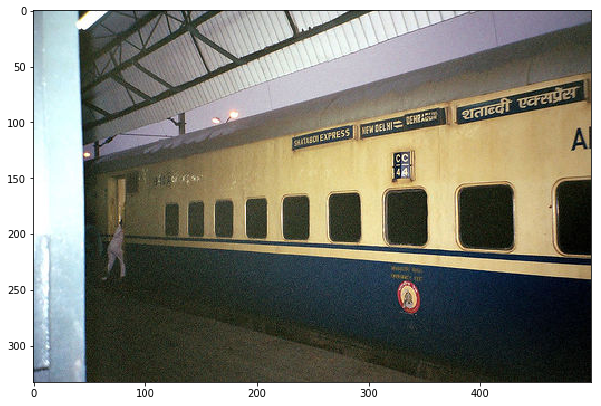

In [372]:
# image = cv2.imread('./data/example.jpg', cv2.IMREAD_COLOR)  # uncomment if dataset not downloaded
%matplotlib inline
from matplotlib import pyplot as plt
from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
# here we specify year (07 or 12) and dataset ('test', 'val', 'train') 
testset = VOCDetection(VOC_ROOT, [('2012', 'trainval')], None, VOCAnnotationTransform())
img_id = 1
image = testset.pull_image(img_id)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

In [358]:
image.shape

(375, 500, 3)

## Pre-process the input.  
#### Using the torchvision package, we can create a Compose of multiple built-in transorm ops to apply 
For SSD, at test time we use a custom BaseTransform callable to
resize our image to 300x300, subtract the dataset's mean rgb values, 
and swap the color channels for input to SSD300.

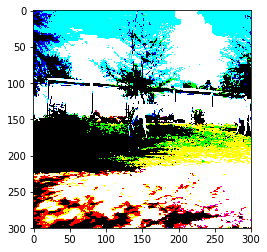

In [359]:
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

## SSD Forward Pass
### Now just wrap the image in a Variable so it is recognized by PyTorch autograd

In [360]:
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
y = net(xx)

## Parse the Detections and View Results
Filter outputs with confidence scores lower than a threshold 
Here we choose 60% 

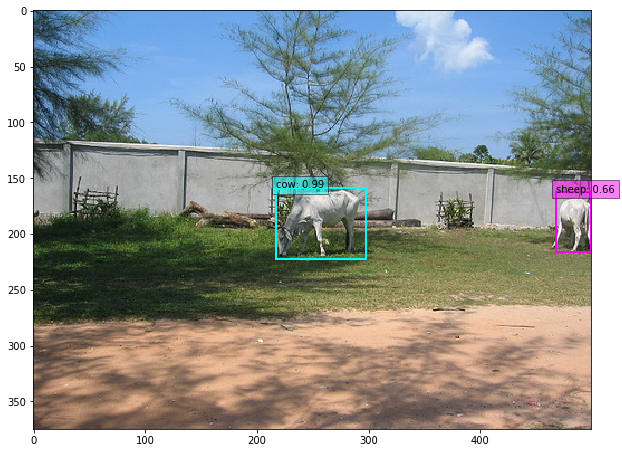

In [361]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

In [362]:
coords

((468.2144, 162.41437), 31.009490966796875, 53.91949462890625)

In [363]:
detections = y.data
detections.size()

torch.Size([1, 21, 200, 5])

In [364]:
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
scale


 500
 375
 500
 375
[torch.FloatTensor of size 4]

In [365]:
detections = y.data
coords_list = []
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        print (pt)
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        coords_list.append(coords)
        print(coords)
        color = colors[i]
        print (color)
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

[216.9036  158.78667 297.0213  221.77951]
((216.9036, 158.78667), 81.11770629882812, 63.99284362792969)
[0.0, 1.0, 0.9647031631761764, 1.0]
[468.2144  162.41437 498.22388 215.33386]
((468.2144, 162.41437), 31.009490966796875, 53.91949462890625)
[0.9878673536761773, 0.0, 0.9617652926476454, 1.0]


In [366]:
coords_list

[((216.9036, 158.78667), 81.11770629882812, 63.99284362792969),
 ((468.2144, 162.41437), 31.009490966796875, 53.91949462890625)]

In [354]:
# boat
coords = ((403.2409, 77.107), 63.025177001953125, 34.228660583496094)
color = [0.8187488187488188, 1.0, 0.0, 1.0]

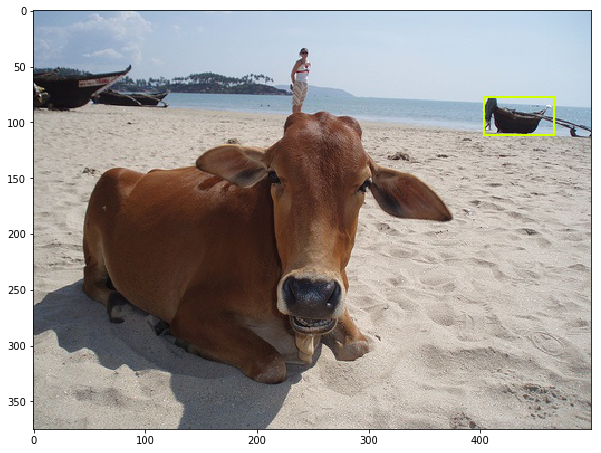

In [232]:
plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()
currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))

In [233]:
rgb_image

array([[[126, 160, 187],
        [126, 160, 188],
        [127, 158, 187],
        ...,
        [176, 200, 224],
        [175, 199, 223],
        [175, 199, 223]],

       [[128, 159, 187],
        [129, 160, 188],
        [129, 160, 189],
        ...,
        [175, 201, 224],
        [175, 201, 224],
        [175, 201, 224]],

       [[129, 160, 188],
        [131, 162, 190],
        [132, 163, 191],
        ...,
        [176, 202, 225],
        [175, 201, 224],
        [175, 201, 224]],

       ...,

       [[165, 162, 153],
        [194, 190, 181],
        [167, 164, 155],
        ...,
        [180, 174, 162],
        [185, 179, 167],
        [179, 173, 161]],

       [[173, 170, 161],
        [149, 145, 136],
        [168, 165, 156],
        ...,
        [164, 158, 146],
        [169, 163, 151],
        [160, 154, 142]],

       [[168, 165, 156],
        [161, 158, 149],
        [167, 164, 155],
        ...,
        [156, 149, 141],
        [159, 152, 144],
        [161, 154, 146]]

In [234]:
#boat ((403.2409, 77.107), 63.025177001953125, 34.228660583496094)
# cow((42.244553, 90.45427), 332.80950927734375, 241.90074157714844)
coords_list

[((403.2409, 77.107), 63.025177001953125, 34.228660583496094),
 ((42.244553, 90.45427), 332.80950927734375, 241.90074157714844)]

In [238]:
mydic = []
for i in range(len(coords_list)):
    dic = {
    "height": int(coords_list[i][2]),
    "width": int(coords_list[i][1]),
    "x": int(coords_list[i][0][0]),
    "y": int(coords_list[i][0][1])
    }
    mydic.append(dic)
    

In [239]:
mydic

[{'height': 34, 'width': 63, 'x': 403, 'y': 77},
 {'height': 241, 'width': 332, 'x': 42, 'y': 90}]

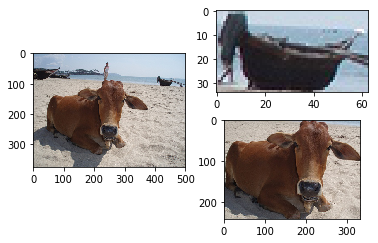

In [240]:
import matplotlib.pyplot as plt

def crop(dic, i, rgb_image):
    image = rgb_image
    x0 = dic[i]["x"]
    y0 = dic[i]["y"]
    width = dic[i]["width"]
    height = dic[i]["height"]
    return image[y0:y0+height , x0:x0+width, :]


fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(rgb_image)

ax1 = fig.add_subplot(222)
boat_patch = crop(mydic, 0, rgb_image)
ax1.imshow(boat_patch)

ax2 = fig.add_subplot(224)
cow_patch = crop(mydic, 1, rgb_image)
ax2.imshow(cow_patch)

plt.show()

In [241]:
j = 1

In [242]:
from PIL import Image
import numpy as np
for i in range(len(coords_list)):
    object_patch = crop(mydic, i, rgb_image)
    object_img = Image.fromarray(object_patch, 'RGB')
    object_img.save("/Users/Sean/Desktop/img_{}_obj_{}.jpg".format(j,i))

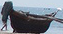

In [21]:
# convert to png 
from PIL import Image
import numpy as np
img_boat = Image.fromarray(boat_patch, 'RGB')
img_boat.save("/Users/Sean/Desktop/img_boat.jpg")
img_boat

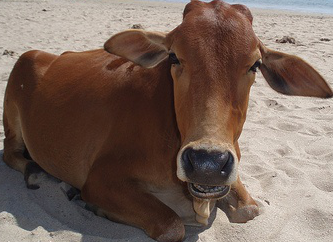

In [22]:
img_cow = Image.fromarray(cow_patch, 'RGB')
img_cow.save("/Users/Sean/Desktop/img_cow.jpg")
img_cow

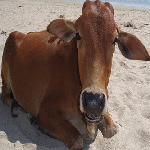

In [23]:
# image resampling
img_cow.resize((150, 150, ))

In [407]:
number_of_image = len(testset)
number_of_image

11540

In [374]:
import os
import sys
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
from ssd import build_ssd

net = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights('../weights/ssd300_mAP_77.43_v2.pth')

from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
from data import VOC_CLASSES as labels
top_k=10

# here we specify year (07 or 12) and dataset ('test', 'val', 'train')
testset = VOCDetection(VOC_ROOT, [('2012', 'trainval')], None, VOCAnnotationTransform())


number_of_image = len(testset)

for img_id in range(10):


    image = testset.pull_image(img_id)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    x = cv2.resize(image, (300, 300)).astype(np.float32)
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    x = torch.from_numpy(x).permute(2, 0, 1)

    xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
    if torch.cuda.is_available():
        xx = xx.cuda()
    y = net(xx)

    detections = y.data
    coords_list = []
    for i in range(detections.size(1)):
        j = 0
        while detections[0,i,j,0] >= 0.6:
            score = detections[0,i,j,0]
            pt = (detections[0,i,j,1:]*scale).cpu().numpy()
            coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
            coords_list.append(coords)
            color = colors[i]
            j+=1

    #{'a':(1 if i<2 else 4) for key, value in dic.items() }
    mydic = []
    for i in range(len(coords_list)):

        # x
        if int(coords_list[i][0][0])< 0:
            x = 0
        elif int(coords_list[i][0][0])>500:
            x = 500
        else:
            x = int(coords_list[i][0][0])

        # y
        if int(coords_list[i][0][1])< 0:
            y = 0
        elif int(coords_list[i][0][1])>375:
            y = 375
        else:
            y = int(coords_list[i][0][1])

        # width
        if int(coords_list[i][1])< 0:
            width = 0
        elif int(coords_list[i][1])>500:
            width = 500
        else:
            width = int(coords_list[i][1])

        # height
        if int(coords_list[i][2])< 0:
            height = 0
        elif int(coords_list[i][2])>375:
            height = 375
        else:
            height = int(coords_list[i][2])

        dic = {
        "height":height ,
        "width": width,
        "x": x,
        "y": y
        }
        mydic.append(dic)
        
    print ('img{}'.format(img_id), mydic)
    # plot
    save_dir = "/Users/Sean/Desktop/OOIS"
    from PIL import Image
    import numpy as np
    for i in range(len(coords_list)):
        object_patch = crop(mydic, i, rgb_image)
        object_img = Image.fromarray(object_patch, 'RGB')
        object_img.save(save_dir + "/img_{}_obj_{}.jpg".format(img_id,i))

/Users/Sean/Desktop/ds1008_final_project/ssd
Loading weights into state dict...
Finished!
img0 [{'height': 260, 'width': 413, 'x': 35, 'y': 12}]
img1 [{'height': 362, 'width': 443, 'x': 48, 'y': 10}]
img2 [{'height': 57, 'width': 461, 'x': 0, 'y': 229}]
img3 [{'height': 298, 'width': 443, 'x': 40, 'y': 73}, {'height': 116, 'width': 135, 'x': 157, 'y': 30}]
img4 [{'height': 63, 'width': 81, 'x': 216, 'y': 158}, {'height': 53, 'width': 31, 'x': 468, 'y': 162}]
img5 [{'height': 199, 'width': 110, 'x': 267, 'y': 0}, {'height': 176, 'width': 100, 'x': 59, 'y': 7}]
img6 [{'height': 334, 'width': 310, 'x': 84, 'y': 15}]
img7 [{'height': 281, 'width': 232, 'x': 137, 'y': 6}, {'height': 150, 'width': 130, 'x': 368, 'y': 7}, {'height': 199, 'width': 163, 'x': 168, 'y': 107}]
img8 [{'height': 138, 'width': 495, 'x': 0, 'y': 149}]
img9 [{'height': 243, 'width': 128, 'x': 54, 'y': 70}, {'height': 59, 'width': 63, 'x': 264, 'y': 25}, {'height': 61, 'width': 53, 'x': 201, 'y': 21}, {'height': 63, 'wi

In [373]:
pwd

'/Users/Sean/Desktop/ds1008_final_project/ssd/demo'